The [Phoible](https://phoible.org/) dataset contains phoneme inventories for thousands of languages and dialects. Many languages/dialicts have multiple Phoible records. Here, I'm mapping the data against pre-prepared IPA phoneme tables, then selecting one sample per table per language so that each language is only represented once in the final dataset (to avoid bias by oversampling).



In [488]:
from pathlib import Path
import requests
from tqdm import tqdm

phoible_data_url = "https://raw.githubusercontent.com/phoible/dev/v2.0/data/phoible.csv"
phobile_file_path = "./downloads/phoible.csv"

VALIDATE_RESULTS = True

if not Path(phobile_file_path).exists():
    response = requests.get(phoible_data_url, stream=True)

    with open(phobile_file_path, "wb") as fh:
        for data in tqdm(response.iter_content()):
            fh.write(data)

In [489]:
import matplotlib.pyplot as plt

%matplotlib inline
import pandas as pd
import numpy as np

phoible_df = pd.read_csv(phobile_file_path, encoding="utf-8", engine="python")

lang_by_dialect_df = (
    phoible_df[["LanguageName", "SpecificDialect", "Phoneme"]]
    .fillna({"SpecificDialect": "none"})
    .groupby(["LanguageName", "SpecificDialect"])
)

language_names = (
    phoible_df[["LanguageName", "SpecificDialect"]]
    .drop_duplicates()
    .reset_index(drop=True)
    .to_numpy()[:, 0]
)

num_lang = len(lang_by_dialect_df)

phoible_df.shape, num_lang

((105467, 48), 2949)

In [490]:
# util


def map_long_phonemes(c):
    return c + "ː" if isinstance(c, str) else c


def create_symbol_matrix(phoneme_type_tbl_df):
    phoneme_type_long_tbl_df = phoneme_type_tbl_df.map(
        map_long_phonemes
    )
    symbols = set(
        phoneme_type_tbl_df.stack().replace("", np.nan).dropna().unique().tolist()
    )
    symbols_long = set([c + "ː" for c in symbols])

    def map_phonemes(df):
        phonemes = set(df.Phoneme.to_list())
        valid_symbols = phonemes.intersection(symbols)
        valid_symbols_long = phonemes.intersection(symbols_long)

        standard = np.where(phoneme_type_tbl_df.isin(valid_symbols), 1.0, 0.0)
        long = np.where(phoneme_type_long_tbl_df.isin(valid_symbols_long), 1.0, 0.0)
        empty = np.zeros(standard.shape)

        result = np.stack([standard, long, empty], axis=2)

        if VALIDATE_RESULTS:
            for row, _ in enumerate(standard):
                for col, _ in enumerate(standard.T):
                    assert standard[row][col] + long[row][col] == result[row][col].sum()

            assert standard.sum() == len(valid_symbols)
            assert long.sum() == len(valid_symbols_long)
            assert result.sum() == standard.sum() + long.sum() + empty.sum()

        return result

    return map_phonemes

Generate pulomic consonants table.

In [491]:
cons_pl_tbl_df = pd.read_csv("./data/consonants_plumonic.csv", dtype=str, index_col=[0], keep_default_na=False, na_values=["-1"])
cons_pl_tbl_df

,Bilabial,Bilabial_v,Labiodental,Labiodental_v,Dental,Dental_v,Alveolar,Alveolar_v,Postalveolar,Postalveolar_v,...,Palatal,Palatal_v,Velar,Velar_v,Uvular,Uvular_v,Pharyngeal,Pharyngeal_v,Glottal,Glottal_v
Plosive,p,b,,,t̪,d̪,t,d,,,...,c,ɟ,k,ɡ,q,ɢ,,NaN,ʔ,NaN
Nasal,,m,,ɱ,,n̪,,n,,,...,,ɲ,,ŋ,,ɴ,NaN,NaN,NaN,NaN
Trill,,ʙ,,,,r̪,,r,,,...,,,NaN,NaN,,ʀ,,,NaN,NaN
Tap or Flap,,,,ⱱ,,ɾ̪,,ɾ,,,...,,,NaN,NaN,,,,,NaN,NaN
Fricative,ɸ,β,f,v,θ,ð,s,z,ʃ,ʒ,...,ç,ʝ,x,ɣ,χ,ʁ,ħ,ʕ,h,ɦ
Lateral fricative,NaN,NaN,NaN,NaN,,,ɬ,ɮ,,,...,,,,,,,NaN,NaN,NaN,NaN
Approximant,,,,ʋ,,,,ɹ,,,...,,j,,ɰ,,,,,NaN,NaN
Lateral approximant,NaN,NaN,NaN,NaN,,l̪,,l,,,...,,ʎ,,ʟ,,,NaN,NaN,NaN,NaN


In [492]:
cons_pl_npy = np.stack(lang_by_dialect_df.apply(create_symbol_matrix(cons_pl_tbl_df), include_groups=False).to_numpy())
assert cons_pl_npy.shape == (num_lang, *cons_pl_tbl_df.shape, 3)
cons_pl_npy.shape

(2949, 8, 22, 3)

Generate non-pulomic consonants table.

In [493]:
cons_npl_tbl_df = pd.read_csv(
    "./data/consonants_non_plumonic.csv",
    dtype=str,
    index_col=[0],
    keep_default_na=False,
    na_values=["-1"],
)
cons_npl_tbl_df

,0,1,2,3,4,5,6,7
Ejective Stop,pʼ,tʼ,ʈʼ,cʼ,kʼ,qʼ,ʡʼ,
Ejective Fricative,fʼ,θʼ,sʼ,ʃʼ,ʂʼ,ɕʼ,xʼ,χʼ
Ejective Affricate,tsʼ,t̠ʃʼ,ʈʂʼ,kxʼ,qχʼ,,,
Ejective Lateral,ɬʼ,tɬʼ,cʎ̝̊ʼ,kʟ̝̊ʼ,,,,
Click,kʘ,kǀ,kǃ,kǂ,kǁ,,,
Implosive Voiced,ɓ,ɗ,ᶑ,ʄ,ɠ,ʛ,,
Implosive Voiceless,ɓ̥,ɗ̥,ᶑ̥,ʄ̥,ɠ̊,ʛ̥,,


In [494]:
cons_npl_npy = np.stack(
    lang_by_dialect_df.apply(
        create_symbol_matrix(cons_npl_tbl_df), include_groups=False
    ).to_numpy()
)
assert cons_npl_npy.shape == (num_lang, *cons_npl_tbl_df.shape, 3)
cons_npl_npy.shape

(2949, 7, 8, 3)

Generate vowel table.

In [495]:
vowels_tbl_df = pd.read_csv(
    "./data/vowels.csv",
    dtype=str,
    index_col=[0],
    keep_default_na=False,
    na_values=["-1"],
)
vowels_tbl_df

,Front unrounded,Front rounded,Near-front unrounded,Near-front rounded,Central unrounded,Central rounded,Near-back unrounded,Near-back rounded,Back unrounded,Back rounded
Close,i,y,,,ɨ,ʉ,,,ɯ,u
Near-close,,,ɪ,ʏ,,,,ʊ,,
Close-mid,e,ø,,,ɘ,ɵ,,,ɤ,o
Mid,e̞,ø̞,,,ə,,,,ɤ̞,o̞
Open-mid,ɛ,œ,,,ɜ,ɞ,,,ʌ,ɔ
Near-open,æ,,,ɐ,,,,,,
Open,a,ɶ,,,ä,,,,ɑ,ɒ


In [496]:
vowels_npy = np.stack(
    lang_by_dialect_df.apply(
        create_symbol_matrix(vowels_tbl_df), include_groups=False
    ).to_numpy()
)
assert vowels_npy.shape == (num_lang, *vowels_tbl_df.shape, 3)
vowels_npy.shape

(2949, 7, 10, 3)

In [497]:
assert cons_pl_npy.shape[0] == cons_npl_npy.shape[0] == vowels_npy.shape[0]

(cons_pl_npy.shape, cons_npl_npy.shape, vowels_npy.shape)

((2949, 8, 22, 3), (2949, 7, 8, 3), (2949, 7, 10, 3))

For languages that have multiple samples in the Phoible dataset, we pick just one sample. Based on previous analysis, the best option seems to be to just pick the one whith the most phonemes per language, as this generally has more information (for example long and short versions of the phonemes).

In [498]:
unique_names = np.unique(language_names)
print(language_names.shape, unique_names.shape)

cons_pl_selected = np.array(
    [np.max(cons_pl_npy[language_names == name], axis=0) for name in unique_names]
)
cons_npl_selected = np.array(
    [np.max(cons_npl_npy[language_names == name], axis=0) for name in unique_names]
)
vowels_selected = np.array(
    [np.max(vowels_npy[language_names == name], axis=0) for name in unique_names]
)

npl = np.sum(cons_npl_npy, axis=(1, 2, 3))
npl_selected = np.array(
    [np.max(npl[language_names == name], axis=0) for name in unique_names]
)
cons_npl_selected_sums = np.sum(cons_npl_selected, axis=(1,2,3))
# sense check
for name in unique_names:
    assert cons_pl_npy[language_names == name].shape[1:] == cons_pl_selected.shape[1:]
    assert cons_npl_npy[language_names == name].shape[1:] == cons_npl_selected.shape[1:]
    assert vowels_npy[language_names == name].shape[1:] == vowels_selected.shape[1:]

cons_pl_selected.shape, cons_npl_selected.shape, vowels_selected.shape

(2949,) (2740,)


((2740, 8, 22, 3), (2740, 7, 8, 3), (2740, 7, 10, 3))

In [499]:
np.save("./data/consonants_plumonic.npy", cons_pl_selected)
np.save("./data/consonants_non_plumonic.npy", cons_npl_selected)
np.save("./data/vowels.npy", vowels_selected)

Merge all the data into a single 4d array. Each language is represented by a 3d matrix, with columns of the 3 phoneme types stacked vertically in 3 groups and a padding row between each group.

In [500]:
max_cols = max(cons_pl_npy.shape[2], cons_npl_npy.shape[2], vowels_npy.shape[2])
max_value = max(np.max(cons_pl_npy), np.max(cons_npl_npy), np.max(vowels_npy))


def get_padding(arr, max_cols):
    return ((0, 0), (0, 0), (0, max_cols - arr.shape[2]), (0, 0))


language_phonemes_npy = np.hstack(
    [
        np.pad(
            cons_pl_npy,
            get_padding(cons_pl_npy, max_cols),
            mode="constant",
        ),
        np.full((cons_pl_npy.shape[0], 1, max_cols, 3), 0.1),
        np.pad(
            cons_npl_npy,
            get_padding(cons_npl_npy, max_cols),
            mode="constant",
        ),
        np.full((cons_pl_npy.shape[0], 1, max_cols, 3), 0.1),
        np.pad(vowels_npy, get_padding(vowels_npy, max_cols), mode="constant"),
    ]
)

language_phonemes_npy.shape

(2949, 24, 22, 3)

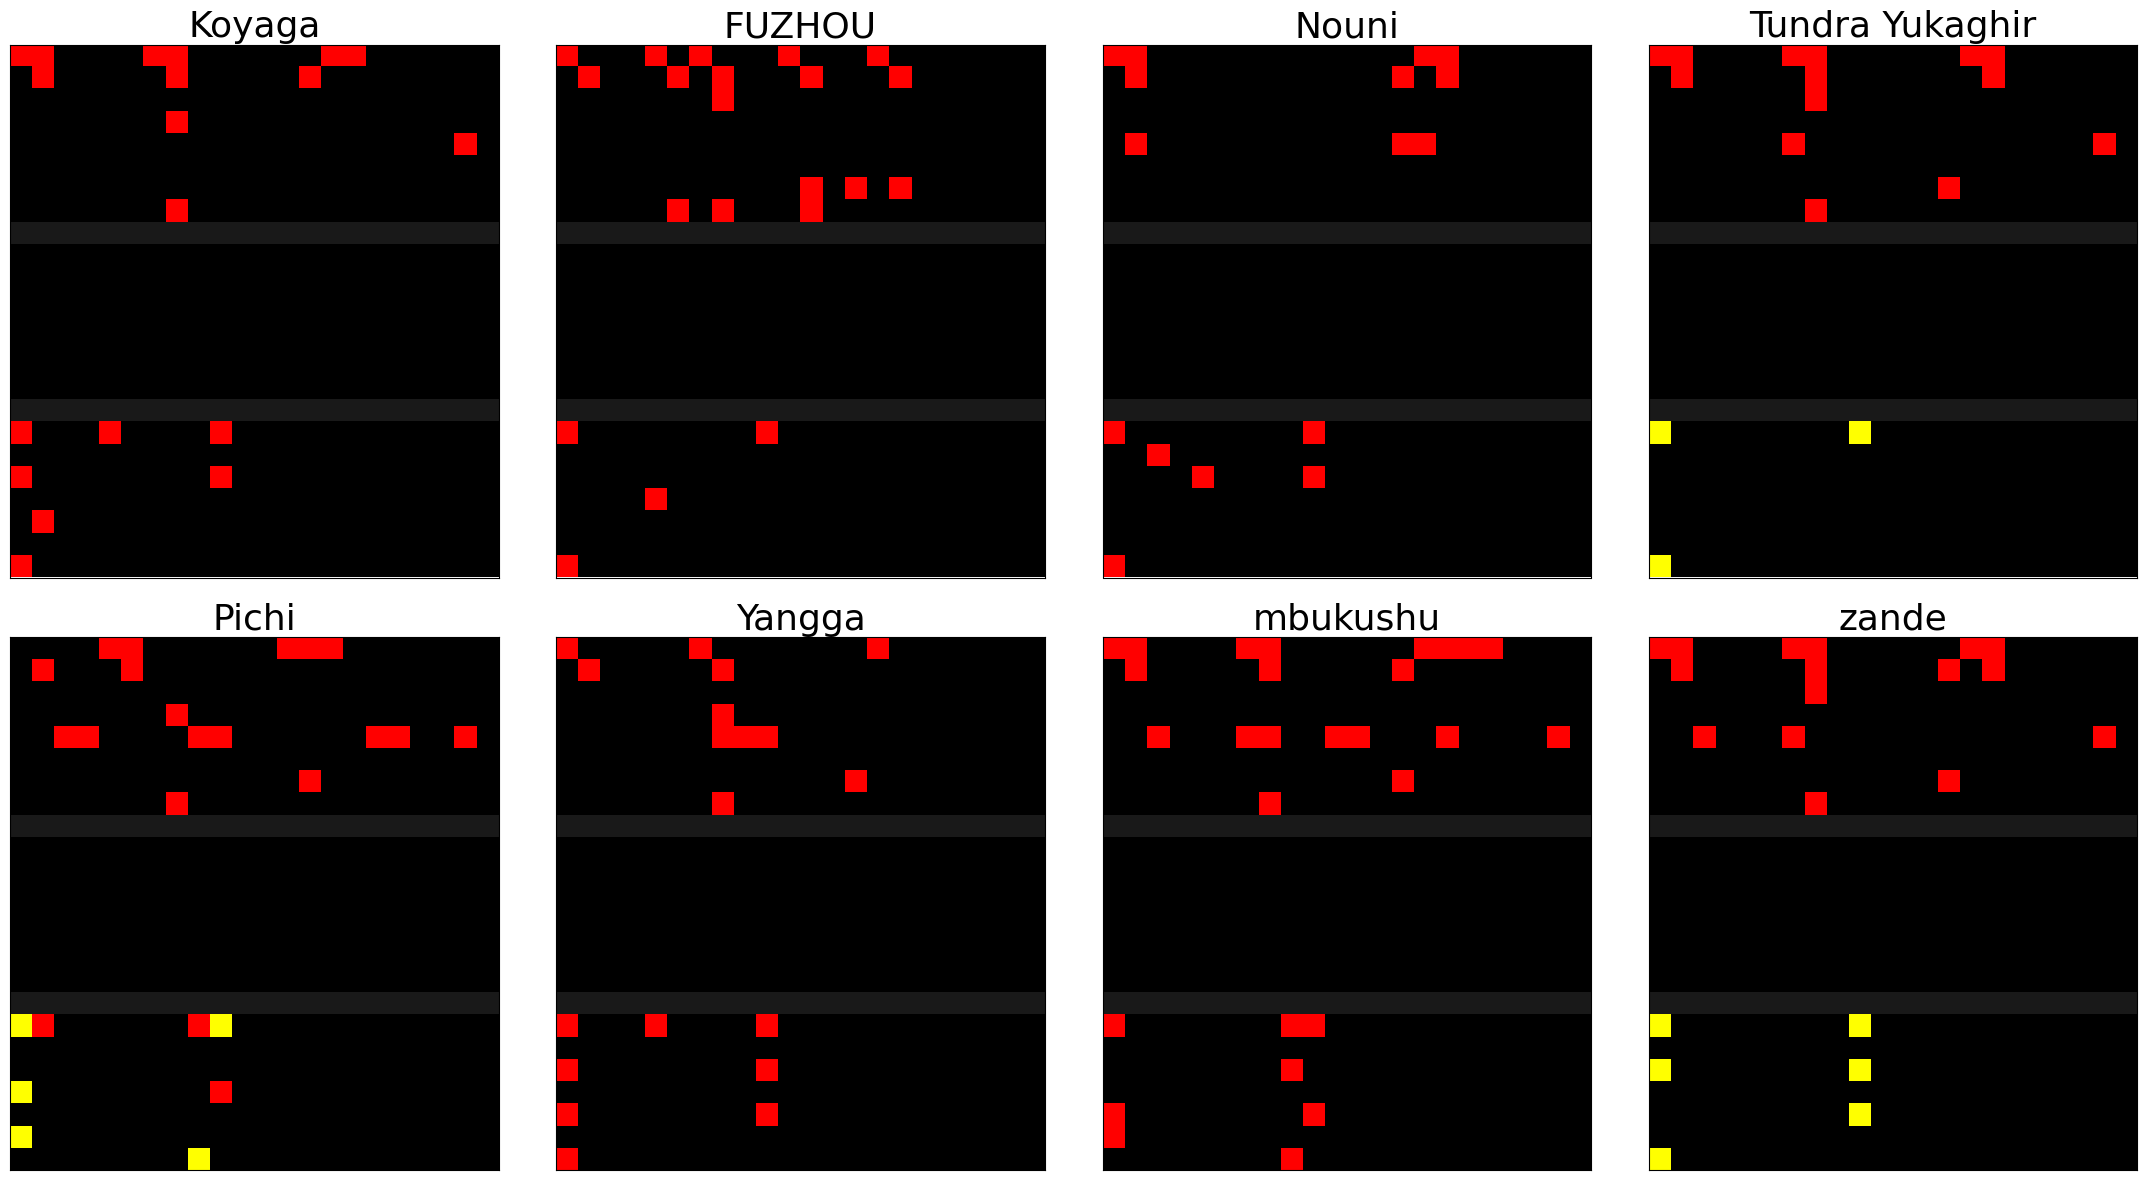

array([1151,  629, 1676, 2205, 1797, 2417, 2661, 2736])

In [501]:
import matplotlib.pyplot as plt

r, c = 2, 4

gen = np.random.default_rng()
sample_indices = gen.choice(unique_names.size, r * c, replace=False)
samples = language_phonemes_npy[sample_indices]
sample_names = unique_names[sample_indices]

fig, axs = plt.subplots(r, c, figsize=(22, 12), linewidth=10)
fig.tight_layout()

cnt = 0
for i in range(r):
    for j in range(c):
        axs[i, j].set_title(sample_names[cnt][0:20], fontsize=26)
        axs[i, j].imshow(samples[cnt])
        axs[i, j].tick_params(
            left=False, right=False, labelleft=False, labelbottom=False, bottom=False
        )
        cnt += 1

plt.show()
sample_indices

In [502]:
np.save("./data/language_phonemes.npy", language_phonemes_npy)

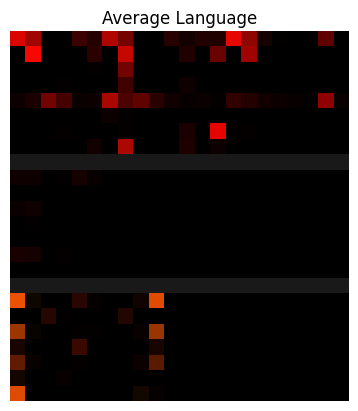

In [503]:
# what does an average language look like?

fig = plt.imshow(
    np.mean(language_phonemes_npy, axis=0),
    cmap=plt.get_cmap("copper_r"),
    vmin=np.min(language_phonemes_npy),
    vmax=np.max(language_phonemes_npy),
)
plt.axis("off")
plt.title("Average Language")
plt.show()

Investigating unhandled phonemes.

In [507]:
handled_symbols = (
    set(cons_pl_tbl_df.stack().replace("", np.nan).dropna().unique())
    | set(cons_npl_tbl_df.stack().replace("", np.nan).dropna().unique())
    | set(vowels_tbl_df.stack().replace("", np.nan).dropna().unique())
)
handled_symbols_long = set([c + "ː" for c in handled_symbols])
all_handled_symbols = handled_symbols | handled_symbols_long

Phoneme
w        2483
t̠ʃ      1218
d̠ʒ       820
ts        666
kʰ        605
         ... 
ɡǂkxʼ       1
ɡǂkʰ        1
ɡǁkxʼ       1
ɡǁkʰ        1
a̰ṵ        1
Name: count, Length: 2941, dtype: int64


,LanguageName,Phoneme
1,!Xóõ,126.0
0,!XU,107.0
2,!Xun,94.0
1979,Soghpo Tibetan,85.0
1424,Mbembe,84.0
...,...,...
1791,Pisamira,1.0
2149,Tiwi,1.0
2619,lingala,1.0
1380,Mapoyo,1.0


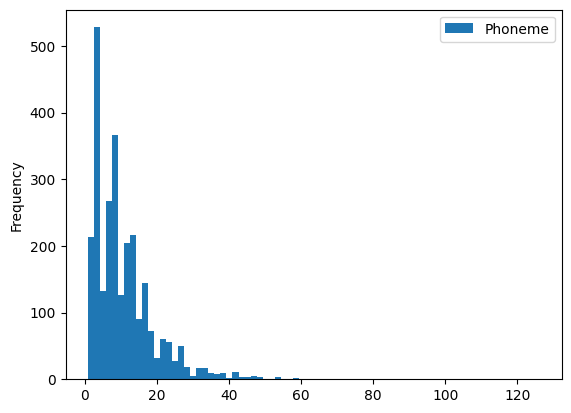

In [505]:
unhandled_symbols = phoible_df[~phoible_df.Phoneme.isin(all_handled_symbols)][
    ["LanguageName", "SpecificDialect", "Phoneme"]
]

unique_unhandled_symbols = unhandled_symbols.Phoneme.value_counts()

print(unique_unhandled_symbols)

unhandled_symbols_by_dialect = (
    unhandled_symbols.fillna({"SpecificDialect": "none"})
    .drop_duplicates()
    .groupby(["LanguageName", "SpecificDialect"])
)

unhandled_counts = (
    unhandled_symbols_by_dialect.count()
    .reset_index()
    .groupby("LanguageName")
    .mean("Phoneme")
    .reset_index()
    .sort_values("Phoneme", ascending=False)
)

unhandled_counts.plot.hist(bins=75)

unhandled_counts